In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm import tqdm
import cv2
import import_ipynb
#import nbimporter

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

from sklearn.model_selection import train_test_split

In [38]:
# #from '경로' import 'modul이름'
#from Grad_Cam_with_Bert.model import *
#from Grad_Cam_with_Bert.preprocess import *
from model import *
from preprocess import *


### Dataset loading

In [39]:
variety= pd.read_csv('../input/variety.csv',names =['description','variety'] )

### Bert Proprecessing

In [40]:
input_ids, input_labels, attention_masks, num_classes,description =train_test_setting(variety,'variety')#province

### Train, test 구성

In [41]:
train, test, train_labels, test_labels, train_masks, test_masks = train_test_split(input_ids, input_labels, attention_masks, test_size=0.25, random_state=123)

In [42]:
train = torch.tensor(train)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels)

test = torch.tensor(test)
test_masks = torch.tensor(test_masks)
test_labels = torch.tensor(test_labels)

In [43]:
dataset = TensorDataset(train, train_labels, train_masks)
dataloader = DataLoader(dataset, batch_size = 128, shuffle=True)

test_dataset= TensorDataset(test,test_labels,test_masks)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle=True)

In [44]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [45]:
network = Net(len(variety.variety.unique()))
'''
    모델 load 전에 DataParallel 먼저 선언해야함.
'''
network = nn.DataParallel(network).cuda()
#network.load_state_dict(torch.load('model_vgg_province.ckpt'))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr = 1e-3)

### Training

In [46]:
epochs = 10
for e in range(epochs):
    
    start_time = time.time() 
    for i, (train, train_labels,masks) in enumerate(dataloader):
        train = train.cuda()
        labels = train_labels.long().cuda()
        masks = masks.long().cuda()
        
        outputs = network(train,masks)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 ==0:
            print(' Epoch [{} / {}] , step [{}/ {}] Loss: {: .4f}'
            .format(e +1, epochs, i+1, len(dataloader), loss.item()))

            start_time = time.time() 
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print('epoch_min : {} , epoch_sec : {}'.format(epoch_mins,epoch_secs))
#torch.save(network.state_dict(), 'model_vgg_province.ckpt')

 Epoch [1 / 10] , step [100/ 617] Loss:  2.3201
 Epoch [1 / 10] , step [200/ 617] Loss:  2.1548
 Epoch [1 / 10] , step [300/ 617] Loss:  2.0980
 Epoch [1 / 10] , step [400/ 617] Loss:  1.9991
 Epoch [1 / 10] , step [500/ 617] Loss:  1.9103
 Epoch [1 / 10] , step [600/ 617] Loss:  1.8105
epoch_min : 0 , epoch_sec : 7
 Epoch [2 / 10] , step [100/ 617] Loss:  1.6173
 Epoch [2 / 10] , step [200/ 617] Loss:  1.7757
 Epoch [2 / 10] , step [300/ 617] Loss:  1.7136
 Epoch [2 / 10] , step [400/ 617] Loss:  1.7507
 Epoch [2 / 10] , step [500/ 617] Loss:  1.6623
 Epoch [2 / 10] , step [600/ 617] Loss:  1.6847
epoch_min : 0 , epoch_sec : 7
 Epoch [3 / 10] , step [100/ 617] Loss:  1.6029


KeyboardInterrupt: 

### Test

In [47]:
# Test the model
network.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

with torch.no_grad():
    correct = 0
    total = 0
    for i,(test, test_labels,masks) in enumerate(test_loader):
        test = test.cuda()
        test_labels = test_labels.long().cuda()
        masks = masks.long().cuda()

        outputs = network(test,masks)

        _ , predicted = torch.max(outputs.data , 1)

        total += test_labels.size(0)

        correct += (predicted == test_labels).sum().item()

    print('Test Accuracy of the model {} %'.format(100* correct/total))

Test Accuracy of the model 52.87002168207235 %


In [48]:
network.eval()

DataParallel(
  (module): Net(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): BertLayerNorm()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): BertLayerNorm()
                

### Grad_Cam

In [89]:
class GradCam(nn.Module):
    def __init__(self):
        super(GradCam,self).__init__()
        self.gradients = None
        '''
            원래 layer 가져옴.
        '''
        self.network = network
        self.features_bert = self.network.module.bert
        self.features_conv1 = self.network.module.conv1
        #self.features_pool = nn.MaxPool1d(2)     
        
        '''
            특정 layer max pool 이전까지 layer 가져옴.
            target cnn layer index: [3,6,9,12,15,18,21]
        '''
        self.target_conv = self.network.module.cnn[:9] 
        self.remain_conv= self.network.module.cnn[9:]
        self.classifier = self.network.module.classifier
        
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self,x,masks):
        x = self.features_bert(x,masks)[0]
        x = x[11].unsqueeze(1)
        x = self.features_conv1(x)
        x = x.squeeze(3)
        x = self.target_conv(x)
        '''
            이 layer와 최종 노드 gradient를 계산할거임
            gradient가 역전파 과정에서 계산되고 버려지는데 hook을 이용해 잡아둠.
            
        ''' 
        h = x.register_hook(self.activations_hook)
        #x = self.features_pool(x)
        x = self.remain_conv(x)

        x = x.view(-1,128*8)
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x, masks):
        x = self.features_bert(x,masks)[0]
        x = x[11].unsqueeze(1)
        x = self.features_conv1(x)
        x = x.squeeze(3)
        x = self.target_conv(x)
        return x

In [90]:
grad_cam = GradCam()

In [91]:
vocab = list(tokenizer.vocab.keys())

In [92]:
for i,(sentence, label, masks) in enumerate(dataloader):
    sentence = sentence[0].view(1,-1).cuda()
    masks = masks[0].view(1,-1).long().cuda()
    
    pred, output = grad_cam(sentence,masks).max(dim=-1) #마지막 class node중, max가져옴.
    grad_cam.zero_grad()#역전파값 모두 초기화
    pred.backward() #역전파 계산. print찍어보면 이미 cahce 다 비웠음.
    '''
        하지만 계산된 값은 텐서의 .grad 속성에 누적됨.
    '''
    
    #register_hook으로 중간 gradient 붙잡아둠.
    gradients = grad_cam.get_activations_gradient()
    '''
        detach() 현재 계산 기록으로 분리됨. 이후에
        detach()는 in-place함수가 아니라 requires_grad, grad_fn이 각각 False, None인 "새로운" Tensor를 리턴한다!
    '''
    activations = grad_cam.get_activations(sentence,masks).detach()
    
    #global average pooling : 각 채널별로 평균 구함.
    pooled_gradients= torch.mean(gradients, dim=[0, 2])
    
    #각 채널에 채널별 평균을 곱해줌. => 채널별 가중치.
    for k in range(gradients.shape[1]):
        activations[:, k, :] *= pooled_gradients[k]
    
    #그후 전체 channel의 평균 구함 => 픽셀별로 가중치를 가짐.
    heatmap = torch.mean(activations, dim=1).squeeze()
    #heatmap 값, 0 비교해서 큰값 반환. =>relu
    heatmap = np.maximum(heatmap.cpu(), 0)
    #가장 큰값으로 나눠줘서 정규화.
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.view(1,-1).numpy()
    #sentence를 받아와서 그거에 맞게 resize하는게 맞나? 그럼 padding부분이 뒷 단어 부분애 매칭되서 안될듯.
    heatmap = cv2.resize(heatmap, dsize=(138,1))

    print("gradient가 가장 큰 단어",heatmap.argmax(),'번째: ', vocab[sentence[0,heatmap.argmax()]])
    text = ' '.join([vocab[word] for word in sentence[0] if word != 0])
    print(text)
    # ##제거하기.
    
# ## concat한것
    concat_text=''
    for word in sentence[0]:
        if word ==0:
            break
        if vocab[word][0]!='#':
            concat_text += ' '+vocab[word]
        else:
            concat_text +=''+vocab[word][2:]
    print(concat_text)
    if i==0:
        break

gradient가 가장 큰 단어 25 번째:  pin
[CLS] an earth ##i aroma light apr ##ico ##t lemon flavor crisp tang ##i text ##ur add lean medium bo ##di ref ##resh wine made pin ##ot noir grape [SEP]
 [CLS] an earthi aroma light apricot lemon flavor crisp tangi textur add lean medium bodi refresh wine made pinot noir grape [SEP]


In [ ]:
#mask 받아와서 pad부분은 gradient 0으로 바꿔주자.

In [93]:
import seaborn as sns
sns.set()

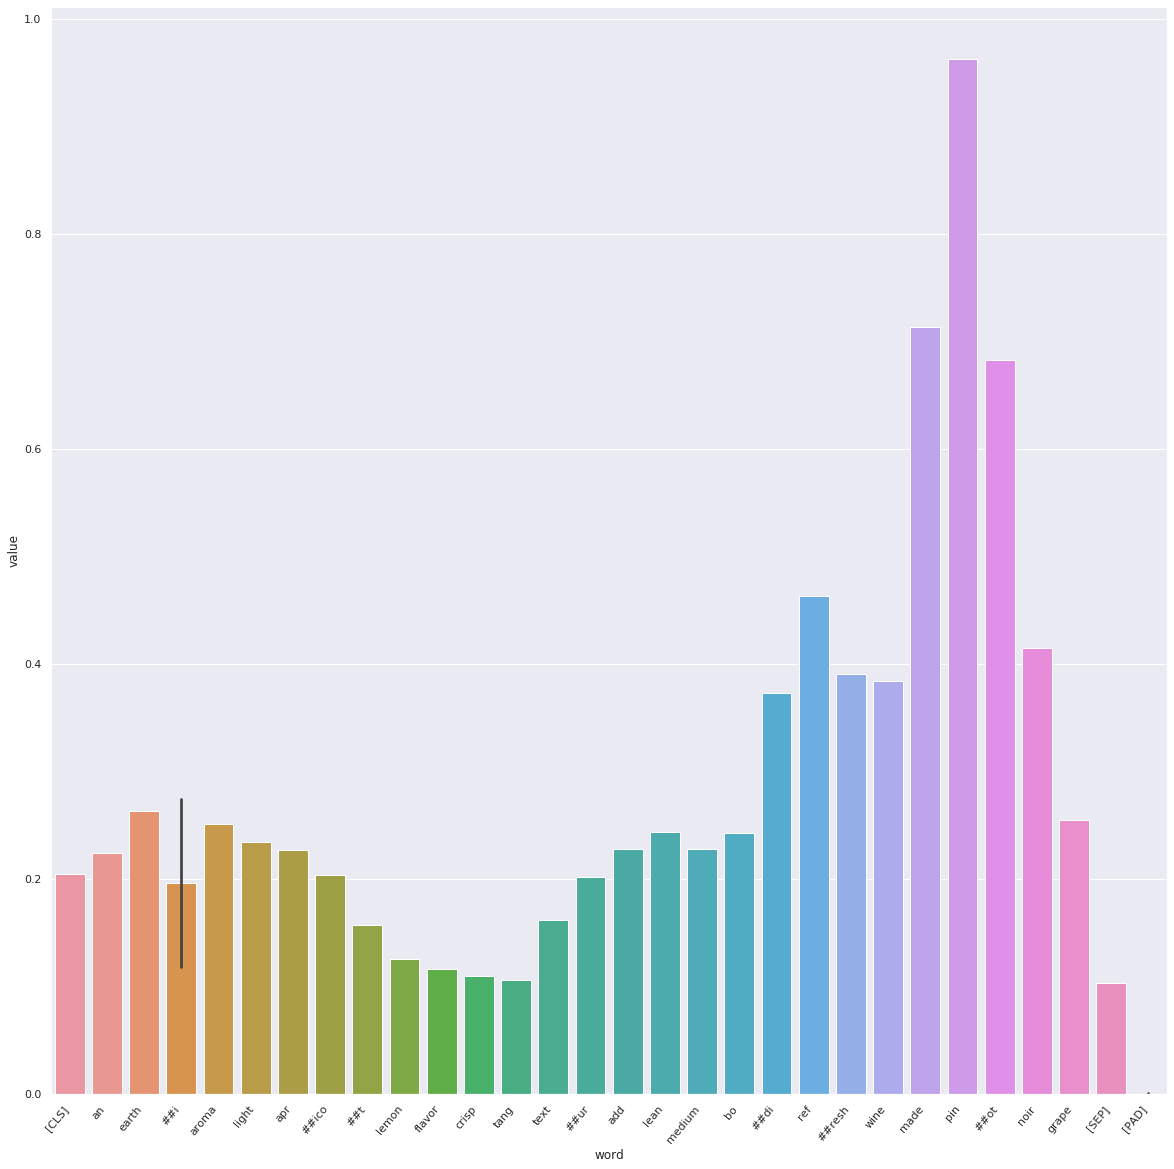

In [94]:
pd_df=[]
for i,word in enumerate(sentence[0]):
    pd_df.append((heatmap[0][i],vocab[word]))
pd_df = pd.DataFrame(pd_df)
pd_df.columns=["value","word"]

plt.figure(figsize=(20,20))
ax=sns.barplot(x="word", y="value", data=pd_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.rcParams["xtick.labelsize"] = 20
plt.show()